In [15]:
#Optimum filter V1.1, adapt to the case where the trace length is longer than the template
import numpy as np
from numpy.fft import rfft, irfft, fft, ifft, fftfreq, rfftfreq
from scipy.signal import fftconvolve

class OptimumFilter():
    
    def __init__(self, template, noise_psd, sampling_frequency):
        self._template = template
        self._noise_psd = noise_psd
        self._sampling_frequency = sampling_frequency
        self._update_state()
        
    def set_template(self, template):
        self._template = template
        self._update_state()
        
    def set_noise_psd(self, noise_psd):
        self._noise_psd = noise_psd
        self._update_state()
        
    def _update_state(self):
        self._length = len(self._template)
        
        if self._length%2==0:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:-1]/2,
                                                       [self._noise_psd[-1]],
                                                       self._noise_psd[-2:0:-1]/2))
        else:
            self._noise_psd_unfolded = np.concatenate(([np.inf],
                                                       self._noise_psd[1:]/2,
                                                       self._noise_psd[-1:0:-1]/2))
            
        
        self._template_fft = fft(self._template)/self._sampling_frequency
        
        self._kernel_fft = self._template_fft.conjugate() / self._noise_psd_unfolded
        self._kernel_normalization = np.real(np.dot(self._kernel_fft, self._template_fft))*self._sampling_frequency/self._length 
        
    def fit(self, trace):

        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._kernel_fft * trace_fft / self._kernel_normalization # Phi * V
        chisq0 = np.real(
            np.dot(trace_fft.conjugate()/self._noise_psd_unfolded,
                   trace_fft)*self._sampling_frequency/self._length
        )
        
        amp0 = np.real(np.sum(
            trace_filtered, axis=-1
        ))*self._sampling_frequency/self._length


        # total chisq
        # self._length-2 is the assumed number of degrees of freedom
        chisq = (chisq0 - (amp0**2)*self._kernel_normalization)/(self._length-2)
        
        return amp0, chisq
    
    def fit_with_shift(self, trace, allowed_shift_range=None):
 
        trace_fft = fft(trace, axis=-1)/self._sampling_frequency # V
        trace_filtered = self._kernel_fft * trace_fft / self._kernel_normalization # Phi * V
        trace_filtered_td = np.real(
            ifft(trace_filtered, axis=-1)
        ) * self._sampling_frequency

        chi0 = np.real(
            np.dot(trace_fft.conjugate()/self._noise_psd_unfolded,
                   trace_fft)*self._sampling_frequency/self._length
        )

        chit_withdelay = (trace_filtered_td**2) * self._kernel_normalization
        chi = chi0 - chit_withdelay
        
        if allowed_shift_range is None:
            ind = np.arange(len(chi))
        else:
            ind = np.concatenate((np.arange(self._length+allowed_shift_range[0], self._length),
                                  np.arange(allowed_shift_range[1]+1)))
        
        best_ind = ind[np.argmin(chi[ind], axis=-1)]
        
        amp = trace_filtered_td[best_ind]
        chisq = chi[best_ind]/(self._length-3)
        t0 = best_ind
        
        return amp, chisq, t0

    def rolling_fit_with_shift(self, trace_long, allowed_shift_range=None):
        L = len(trace_long)
        N = self._length
        fs = self._sampling_frequency

        n_windows = L // N
        amps = np.zeros(n_windows)
        chisqs = np.zeros(n_windows)
        shifts = np.zeros(n_windows, dtype=int)
        positions = np.zeros(n_windows, dtype=int)

        for i in range(n_windows):
            start = i * N
            segment = trace_long[start:start + N]
            amp, chisq, t0 = self.fit_with_shift(segment, allowed_shift_range)

            amps[i] = amp
            chisqs[i] = chisq
            shifts[i] = t0
            positions[i] = start + t0

        return amps, chisqs, shifts, positions
    
    
    def convolve_long_trace(self, trace_long):

        filtered_trace = fftconvolve(trace_long, self._kernel_td[::-1], mode='valid')
        return filtered_trace


In [5]:
import yaml
import numpy as np
from trace_IO import *
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict
sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
sub_template = np.load("templates/sub_ch_template.npy")

noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')


In [ ]:
lts = LongTraceSimulator(config)



In [16]:
vac_of = OptimumFilter(vac_template, noise_psd, sampling_frequency)
sub_of = OptimumFilter(sub_template, noise_psd, sampling_frequency)

In [31]:
trace, idx= lts.generate(
            E=70,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]
amps = []
chisqs = []
shifts = []
positions = []
significant_fits = []
channels = []
all_fit_results = []

# These are for plotting
sub_deltas = []
sub_chisqs = []
vac_deltas = []
vac_chisqs = []

for ch in range(54):
    if ch < 45:
        ampl, chisq, shift, position = sub_of.rolling_fit_with_shift(trace[ch], allowed_shift_range=None)
    else:
        ampl, chisq, shift, position = vac_of.rolling_fit_with_shift(trace[ch], allowed_shift_range=None)
    
    # Store raw arrays
    amps.append(ampl)
    chisqs.append(chisq)
    shifts.append(shift)
    positions.append(position)
    
    # Store per-channel fits for later analysis
    fit_results = [
        {'channel': ch, 'amplitude': a, 'shift': s, 'chisq': c, 'position': p}
        for a, s, c, p in zip(ampl, shift, chisq, position)
    ]
    all_fit_results.extend(fit_results)


In [32]:
threshold = 4.8
for res in all_fit_results:
    pos_error = res['position'] - idx
    amp = res['amplitude']
    ch = res['channel']
    chisq = res['chisq']
    shift_val = res['shift']  # <- Extract the shift here

    if amp > threshold:
        # Check if any other fit in the same channel (excluding this one) has amp > 4
        other_fits = [r for r in all_fit_results if r['channel'] == ch and r != res]
        has_other_significant = any(r['amplitude'] > threshold for r in other_fits)

        print(f"Channel {ch} | Amplitude: {amp:.2f}, Chi²: {chisq:.2f}, Error: {pos_error}, Shift: {shift_val}, Other fit passed?: {has_other_significant}")


Channel 14 | Amplitude: 30.96, Chi²: 0.95, Error: -8, Shift: 5596, Other fit passed?: False
Channel 24 | Amplitude: 33.49, Chi²: 0.96, Error: 10, Shift: 5614, Other fit passed?: False
Channel 50 | Amplitude: 4.88, Chi²: 0.90, Error: -4193, Shift: 1411, Other fit passed?: False


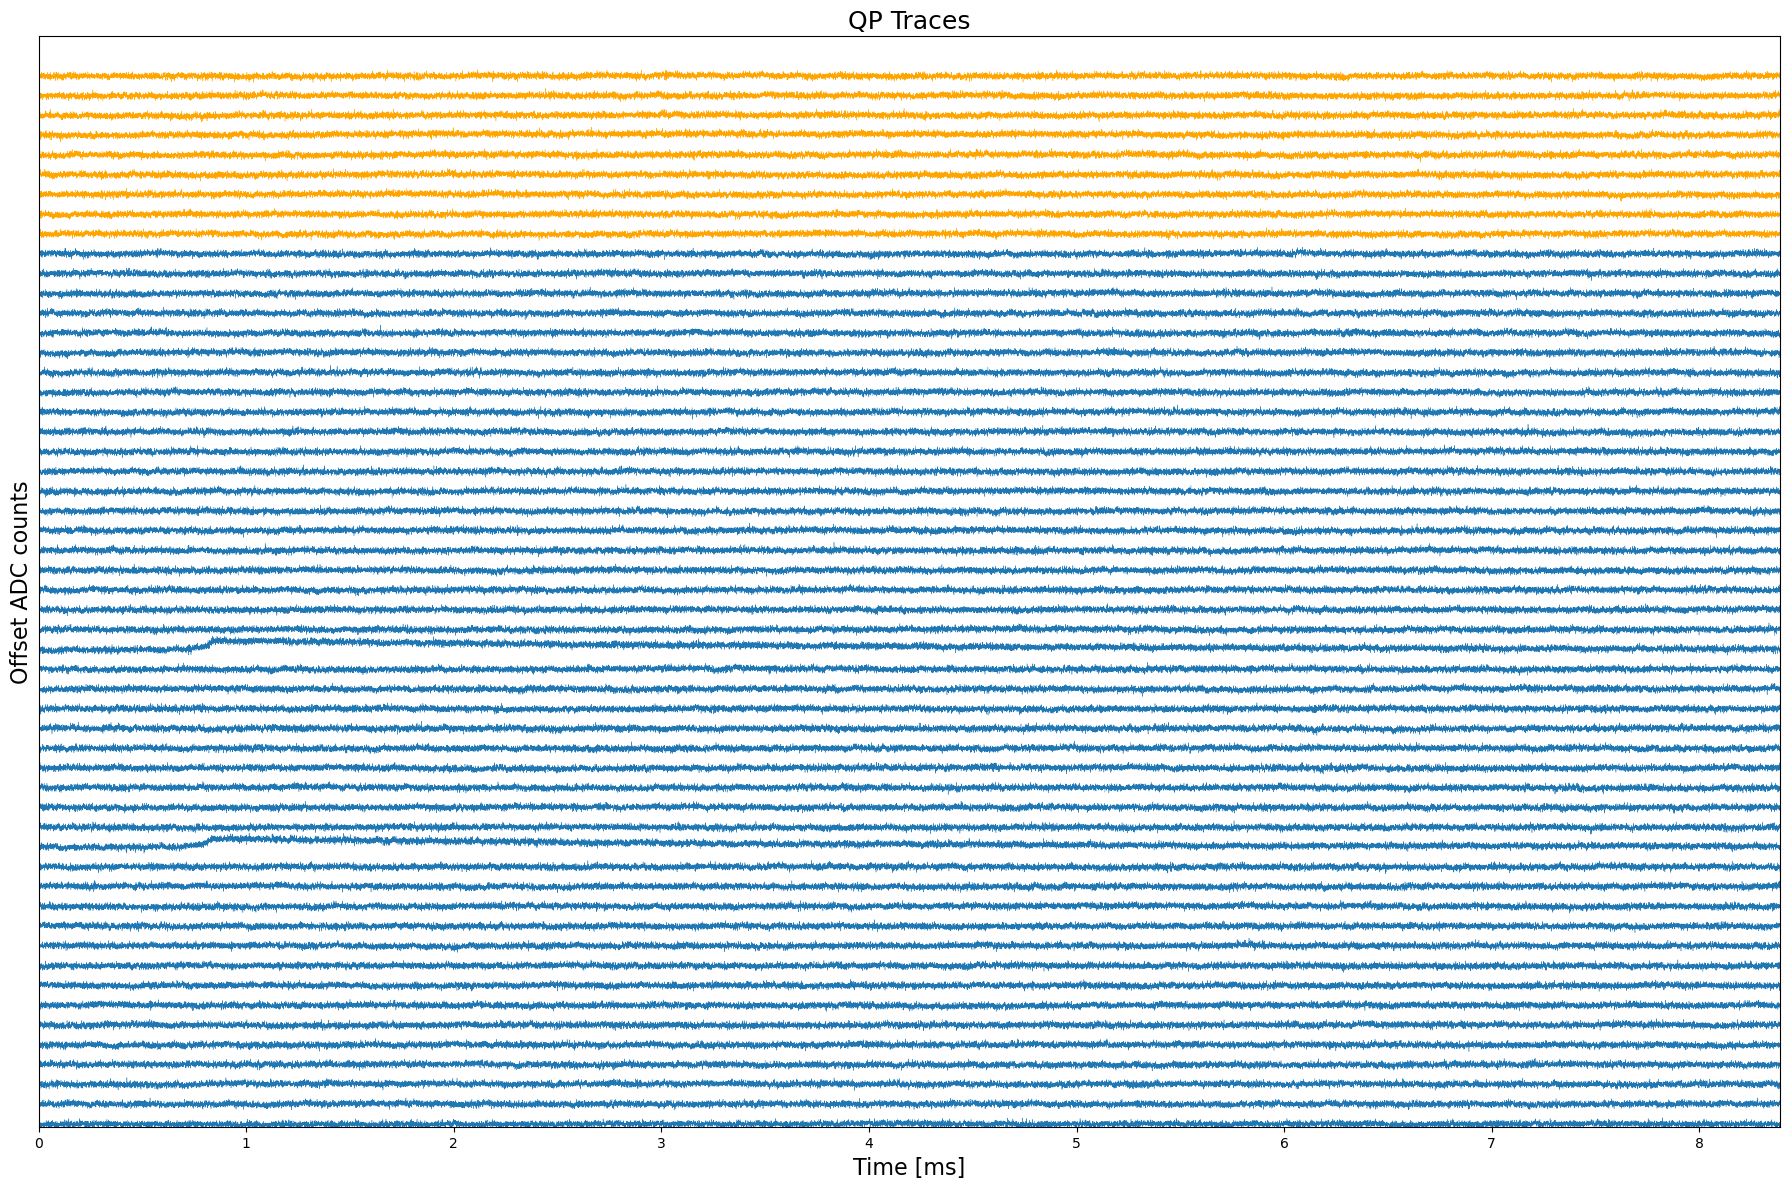

In [33]:
plot_traces(trace[:, idx:idx+32768])